# Kaggle Challenge: Quora Question Pairs
---

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# I. Visualization

In [6]:
d_train = pd.read_csv("train.csv")
d_test = pd.read_csv("test.csv")
d_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [34]:
d_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


Total number of training pairs: 404290
Duplicate pairs: 36.92%
Total number of training questions: 537933
Number of questions appearing multiple times: 111780


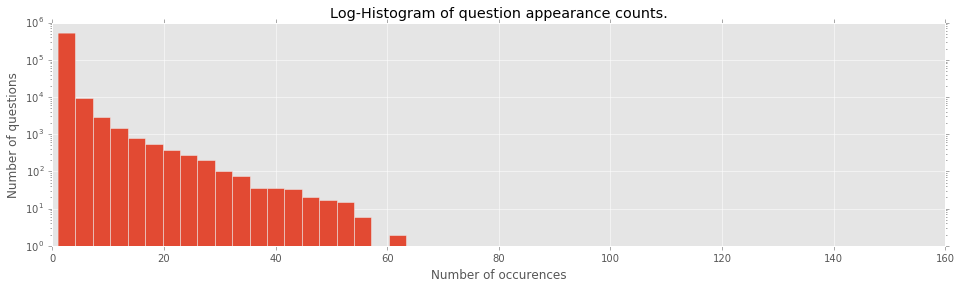

In [7]:
q_ids = pd.concat([d_train['qid1'], d_train['qid2']])

print 'Total number of training pairs: {}'.format(len(d_train))
print 'Duplicate pairs: {}%'.format(round(d_train['is_duplicate'].mean() * 100, 2))

print 'Total number of training questions: {}'.format(len(np.unique(q_ids)))
print 'Number of questions appearing multiple times: {}'.format(np.sum(q_ids.value_counts() > 1))

plt.figure(figsize=(16, 4))
plt.hist(q_ids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts.')
plt.xlabel('Number of occurences')
plt.ylabel('Number of questions');

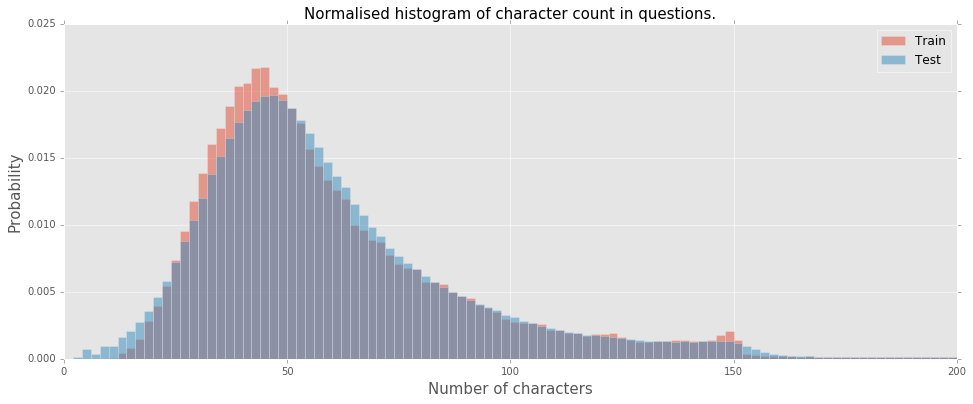

In [8]:
train_qs = pd.concat([d_train['question1'], d_train['question2']]).astype(str)
test_qs = pd.concat([d_test['question1'], d_test['question2']]).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

plt.figure(figsize=(16, 6))
plt.hist(dist_train, bins=100, range=[0, 200], normed=True, alpha=0.5, label='Train')
plt.hist(dist_test, bins=100, range=[0, 200], normed=True, alpha=0.5, label='Test')
plt.title('Normalised histogram of character count in questions.', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15);

# II. Feature Extraction

In [28]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_vectorizer.fit(train_qs.tolist())

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.95, max_features=None, min_df=2,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [33]:
tfidf_vectorizer.vocabulary_

{u'constan\u021ba': 11261,
 u'daiict': 12671,
 u'woods': 50473,
 u'spiders': 43262,
 u'hanging': 21023,
 u'woody': 50478,
 u'localized': 27498,
 u'disobeying': 14395,
 u'gad': 19185,
 u'refunding': 38396,
 u'rickman': 39335,
 u'pigment': 35017,
 u'tourister': 46728,
 u'replaces': 38809,
 u'bringing': 7698,
 u'kaushal': 25562,
 u'vibrational': 49039,
 u'wooden': 50468,
 u'wednesday': 49924,
 u'chameleons': 9279,
 u'crotch': 12195,
 u'330ml': 1073,
 u'thrace': 46161,
 u'mormonthink': 30500,
 u'0051': 8,
 u'desiccant': 13647,
 u'270': 877,
 u'273': 881,
 u'275': 883,
 u'276': 886,
 u'278': 887,
 u'279': 888,
 u'inanimate': 23229,
 u'errors': 16604,
 u'starboy': 43659,
 u'warmongering': 49687,
 u'usenet': 48474,
 u'designing': 13658,
 u'numeral': 32336,
 u'trivikram': 47182,
 u'27k': 889,
 u'bhubaneshwar': 6549,
 u'brainwashed': 7517,
 u'affiliates': 2883,
 u'evolutionist': 16909,
 u'quart': 37291,
 u'kids': 25821,
 u'uplifting': 48348,
 u'controversy': 11445,
 u'neurologist': 31655,
 u'to

In [15]:
def tfidf_word_match_share(row):
    
    q1_words = {}
    q2_words = {}
    
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1_words[word] = 1
            
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2_words[word] = 1
            
    if len(q1_words) == 0 or len(q2_words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [tfidf_vectorizer.transform(w) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

<8944593x51975 sparse matrix of type '<type 'numpy.float64'>'
	with 4159220 stored elements in Compressed Sparse Row format>

In [27]:
train_qs.tolist()

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use \xe3\x82\xb7 instead of \xe3\x81\x97?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?',
 'Method to find separation of slits using fresnel biprism?',
 'How do I read and find my YouTube comments?',
 'What can make Physics easy to learn?',
 'What was your first sexual experience like?',
 'What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?',
 'What would a Trump presidency mean for 